<a href="https://colab.research.google.com/github/rawat126/DL-ML/blob/master/Movie_analysis%20(Unsupervised%20approch)/Movie_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries and connecting with drive

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import cluster
from google.colab import drive
import tensorflow.keras as keras
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [104]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Preprocessing of Data

In [0]:
# function for noramlization
# takes dataframe as input and return the normalized data 

def normalize_to_space(df):
    # here we are using standard Normalization technique
    data = np.asarray(df).reshape(-1,1)
    scale = MinMaxScaler()
    scale.fit(data)
    data = scale.transform(data)

    return pd.DataFrame(data)

Reading our first CSV file..........

In [106]:
# Reading the Actors Data
# this data consist of different features to describe an actor
# but, all are not relevent 

actors_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TF_Course/actors_data.csv')
actors_data.head()

,actorId,actorName,movieCount,ratingSum,normalizedMovieRank,googleHits,normalizedGoogleRank,normalizedRating
0,373,Aamir Khan,11,1170,9.44862,2460000,7.34283,10.00000
1,374,Shah Rukh Khan,23,2000,7.55009,2670000,7.88458,9.22674
2,375,Salman Khan,36,2340,5.40217,3490000,10.00000,9.20821
3,376,Katrina Kaif,17,1640,8.48082,2120000,6.46570,8.94852
4,377,Deepika Padukone,16,1080,5.64674,3000000,8.73591,8.62716


In [107]:
# dropping the un-necessary values
actors_data.drop(['normalizedGoogleRank','normalizedRating','actorId','ratingSum'],axis=1,inplace=True)
actors_data.head()

,actorName,movieCount,normalizedMovieRank,googleHits
0,Aamir Khan,11,9.44862,2460000
1,Shah Rukh Khan,23,7.55009,2670000
2,Salman Khan,36,5.40217,3490000
3,Katrina Kaif,17,8.48082,2120000
4,Deepika Padukone,16,5.64674,3000000


In [108]:
# normalizing the data
for i in actors_data.keys():
    if(i!='actorName'):
        actors_data[i] = normalize_to_space(actors_data[i])

# Aggregating the normalized data
for i in actors_data.keys():
    if(i=='actorName'):
        pass
    else:
      if 'overAll' in actors_data.keys():
          actors_data['overAll'] = actors_data['overAll']+actors_data[i]
      else:
          actors_data['overAll'] = actors_data[i]

# dropping irrelevent columns after Aggregation
actors_data.drop(['movieCount','normalizedMovieRank','googleHits'],axis=1,inplace=True)
actors_data['overAll'].fillna(actors_data['overAll'].median(),inplace=True)
actors_data.head()

,actorName,overAll
0,Aamir Khan,1.847310
1,Shah Rukh Khan,1.918757
2,Salman Khan,2.155797
3,Katrina Kaif,1.753467
4,Deepika Padukone,1.672200


Reading second CSV file..............

In [109]:
# loding director's rating Data

directors_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TF_Course/directors_data.csv')
directors_data.head(10)

,directorId,directorName,movieCount,ratingSum,normalizedMovieRank,googleHits,normalizedGoogleRank,normalizedRating
0,1,Rajkumar Hirani,3,440,10.00000,146000,2.07796,10.00000
1,2,Farah Khan,4,440,7.39474,1060000,8.88317,8.78473
2,3,Karan Johar,5,430,5.68947,1050000,8.80872,7.10460
3,4,Sajid Khan,4,350,5.79605,905000,7.72912,6.99780
4,5,Rohit Shetty,10,950,6.32895,437000,4.24461,6.83761
5,6,Kabir Khan,3,270,5.97368,666000,5.94964,6.82368
6,7,Anil Sharma,6,390,4.19737,1110000,9.25545,5.73447
7,8,Farhan Akhtar,4,290,4.73026,742000,6.51549,5.71973
8,9,Siddharth Anand,5,400,5.26316,312000,3.31392,5.61481
9,10,Anees Bazmee,7,600,5.66917,34400,1.24704,5.60762


In [110]:
# dropping the irrelevent attributes

directors_data.drop(['directorId','ratingSum','normalizedGoogleRank','normalizedRating'],axis = 1,inplace = True)
directors_data.head()

,directorName,movieCount,normalizedMovieRank,googleHits
0,Rajkumar Hirani,3,10.00000,146000
1,Farah Khan,4,7.39474,1060000
2,Karan Johar,5,5.68947,1050000
3,Sajid Khan,4,5.79605,905000
4,Rohit Shetty,10,6.32895,437000


In [111]:
# preprocessing director's dataset

for i in directors_data.keys():
    if(i != 'directorName'):
        directors_data[i] = normalize_to_space(directors_data[i])

# adding weighted mean to final data
directors_data['overAll'] = directors_data['movieCount'] + 1.75*directors_data['normalizedMovieRank'] + directors_data['googleHits']

# removing irrelevent data after preprocessing 
directors_data.drop(['movieCount','normalizedMovieRank','googleHits'],axis=1,inplace=True)

# dealing null values
directors_data['overAll'].fillna(directors_data['overAll'].mean(),inplace=True)
directors_data.dropna(inplace=True)

directors_data.head()

,directorName,overAll
0,Rajkumar Hirani,1.870661
1,Farah Khan,2.181955
2,Karan Johar,1.904610
3,Sajid Khan,1.742999
4,Rohit Shetty,1.834842


Rating Function

In [0]:
# function for converting categorical different variables to defined numerical rating..
# it takes input as data and attribute_name
# returns float DataFrame as output

def convert_to_rate(s,df,actors=actors_data,directors=directors_data):
    data = list(df)
    #print(len(data))
    out  = [0 for i in range(len(data))]
    mean_actors = np.mean(actors['overAll'])
    mean_directors = np.mean(directors['overAll'])
    
    # when the attribute_name is actors
    if(s=='actors'):
        for pos,i in enumerate(data):
            #print(i)
            ite = i.split(' | ')
            for j in ite:
                try:
                    out[pos] = out[pos]+actors['overAll'][list(actors['actorName']).index(j)]
                except ValueError:
                    out[pos] = out[pos]+mean_actors
                    #print(j)
                except KeyError:
                    pass
    
    # when the attribute_name is directors
    if(s=='directors'):
        for pos,i in enumerate(data):
            ite = i.split(' | ')
            for j in ite:
                #print(j)
                try:
                    out[pos] = out[pos]+directors['overAll'][list(directors['directorName']).index(j)]
                except ValueError:
                    out[pos] = out[pos]+mean_directors
                except KeyError:
                    pass

    
    return pd.DataFrame(out)

Reading main CSV file...........

In [124]:
# reading movies dataset

movies_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TF_Course/movies_data.csv')
movies_data.tail()

,imdbId,title,releaseYear,releaseDate,genre,writers,actors,directors,sequel,hitFlop
1279,tt4121522,Shuruaat Ka Interval,2014,15 Aug 2014,NaN,Aarti S. Bagdi | Amrit Raj Gupta | Krishan Hoo...,Kaivalya Chheda | Rajsekhar Aningi | Avidant B...,Aarti S. Bagdi | Amrit Raj Gupta | Krishan Hoo...,0.0,1
1280,tt4187650,Trip to Bhangarh,2014,28 Aug 2014,Horror,NaN,Manish Choudhary | Suzanna Mukherjee | Poonam ...,Jitendra Pawar,0.0,1
1281,tt4190220,Zed Plus,2014,28 Nov 2014,NaN,Chandra Prakash Dwivedi (screen play and dialo...,Adil Hussain | Ekavali Khanna | Kulbhushan Kha...,Chandra Prakash Dwivedi,0.0,1
1282,tt4219300,Gollu aur Pappu,2014,21 Nov 2014,Comedy,NaN,Vir Das | Sandeepa Dhar | Rahul Handa | Dimple...,Kabir Sadanand,0.0,1
1283,tt4228746,Zid,2014,28 Nov 2014,Thriller,Vivek Agnihotri | Rohit Malhotra,Shradha Das | Mohan Kapoor | Mannara | Karanvi...,Rohit Malhotra | Anubhav Sinha,0.0,2


In [125]:
# Dropping the irrelevent columns

movies_data = movies_data.drop(['imdbId','releaseYear','releaseDate','writers'],axis=1)
movies_data.drop([1279,1281,601,797,835,454,437,206,297],axis=0,inplace=True)
movies_data.reset_index(inplace=True)
movies_data.head()

,index,title,genre,actors,directors,sequel,hitFlop
0,0,Albela,Romance,Govinda | Aishwarya Rai Bachchan | Jackie Shro...,Deepak Sareen,0.0,2
1,1,Lagaan: Once Upon a Time in India,Adventure | Drama | Musical,Aamir Khan | Gracy Singh | Rachel Shelley | Pa...,Ashutosh Gowariker,0.0,6
2,2,Meri Biwi Ka Jawab Nahin,Action | Comedy,Akshay Kumar | Sridevi | Gulshan Grover | Laxm...,Pankaj Parashar | S.M. Iqbal,0.0,1
3,3,Hum Tumhare Hain Sanam,Drama | Romance,Shah Rukh Khan | Madhuri Dixit | Salman Khan |...,K.S. Adiyaman,0.0,4
4,4,One 2 Ka 4,Action | Comedy | Drama,Shah Rukh Khan | Juhi Chawla | Jackie Shroff |...,Shashilal K. Nair,0.0,1


In [126]:
# preprocessing the categorical data to rating as per our functions

movies_data['actors'] = convert_to_rate(s='actors',df=movies_data['actors'])
movies_data['directors'] = convert_to_rate(s='directors',df=movies_data['directors'])
#movies_data.drop('index',axis=1,inplace=True)
movies_data['sequel'].fillna(0.0,inplace=True)
movies_data.head()


,index,title,genre,actors,directors,sequel,hitFlop
0,0,Albela,Romance,2.945742,0.616168,0.0,2
1,1,Lagaan: Once Upon a Time in India,Adventure | Drama | Musical,3.314926,0.919639,0.0,6
2,2,Meri Biwi Ka Jawab Nahin,Action | Comedy,3.399386,0.737504,0.0,1
3,3,Hum Tumhare Hain Sanam,Drama | Romance,5.335088,0.616168,0.0,4
4,4,One 2 Ka 4,Action | Comedy | Drama,3.627437,0.369645,0.0,1


#Data Evaluation

In [127]:
# proprocessing the further "genre" attributer to one-hot-encoding

l=[]
for i in movies_data['genre']:
    for j in i.split(' | '):
      for k in j.split(' |'):
        l.append(k)

l1 = set(l)

for i in l1:
    movies_data[i] = np.nan

for i in l1:
    for pos,j in enumerate(movies_data['genre']):
        if i in j:
            movies_data[i][pos]=1
        else:
            movies_data[i][pos]=0

movies_data.drop('genre',axis=1,inplace=True)
#for i in movies_data.iloc[:,4:]:
#    i.astype('int',inplace=True)
movies_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,title,actors,directors,sequel,hitFlop,Romance,Western,War,Documentary,Animation,Horror,Sci-Fi,Mystery,Musical,Adventure,Music,Sport,Family,Comedy,Crime,History,Short,Fantasy,Drama,Action,Thriller,Biography
0,0,Albela,2.945742,0.616168,0.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Lagaan: Once Upon a Time in India,3.314926,0.919639,0.0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,Meri Biwi Ka Jawab Nahin,3.399386,0.737504,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,Hum Tumhare Hain Sanam,5.335088,0.616168,0.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,One 2 Ka 4,3.627437,0.369645,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [131]:
# checking Null values in final Data

movies_data.isnull().sum()

index          0
title          0
actors         0
directors      0
sequel         0
hitFlop        0
Romance        0
Western        0
War            0
Documentary    0
Animation      0
Horror         0
Sci-Fi         0
Mystery        0
Musical        0
Adventure      0
Music          0
Sport          0
Family         0
Comedy         0
Crime          0
History        0
Short          0
Fantasy        0
Drama          0
Action         0
Thriller       0
Biography      0
dtype: int64

# Model Creation (Clusters Creation)
we used the Heirchial Clustring for the cluster
formation of our data accoding to there relations 

In [151]:
# Using KNeighbour Classifier for hitFlop Prediction
# We already tried this classifer and it give accuracy of 72% (best amoung all the classifiers)

from sklearn import neighbors

X = pd.concat((movies_data.iloc[:,2:5],movies_data.iloc[:,6:]),axis=1)
Y = movies_data['hitFlop']

model = neighbors.KNeighborsClassifier()
model.fit(X,Y)

print(X.head())

     actors  directors  sequel  Romance  ...  Drama  Action  Thriller  Biography
0  2.945742   0.616168     0.0      1.0  ...    0.0     0.0       0.0        0.0
1  3.314926   0.919639     0.0      0.0  ...    1.0     0.0       0.0        0.0
2  3.399386   0.737504     0.0      0.0  ...    0.0     1.0       0.0        0.0
3  5.335088   0.616168     0.0      1.0  ...    1.0     0.0       0.0        0.0
4  3.627437   0.369645     0.0      0.0  ...    1.0     1.0       0.0        0.0

[5 rows x 25 columns]


Dendograms

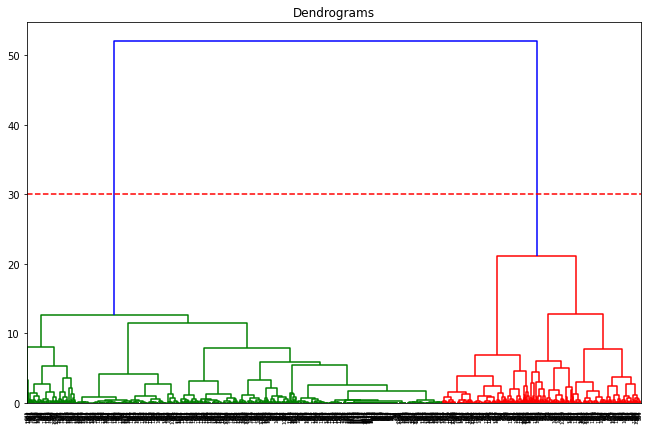

In [177]:
# Creating Dendograms for Proximity matrix
# Dendograms ase basic tree shaped structure used for clustering data
# it give numbers of clusters, relation betweeen different points and 

from scipy.cluster import hierarchy

plt.figure(figsize=(11, 7))  
plt.title("Dendrograms")#pd.concat((movies_data.iloc[:,0],movies_data.iloc[:,2:5]),axis=1)
dend = hierarchy.dendrogram(hierarchy.linkage(movies_data.iloc[:,2:5],method='ward'))
plt.axhline(30,linestyle='--',color='red')

clustring the final Data

In [324]:
# creatring clustering model for movies_data using Agglomerative clustring

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity = 'euclidean')
cluster.fit_predict(movies_data.iloc[:,2:])

array([0, 1, 0, ..., 0, 0, 0])

#Data analysis

creating anlysis aqccording to movie Rating

Text(0.5, 1.0, 'Rating')

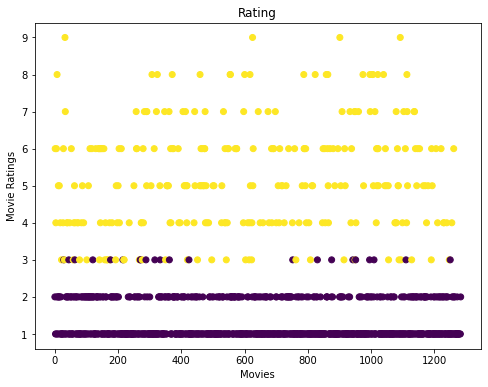

In [159]:
plt.figure(figsize=(8,6))
plt.scatter(movies_data['index'],movies_data['hitFlop'],c=cluster.labels_)
plt.xlabel('Movies')
plt.ylabel('Movie Ratings')
plt.title('''Rating''')

creating analysis according to Star-Cast Rating

Text(0.5, 1.0, 'Star-Cast Rating')

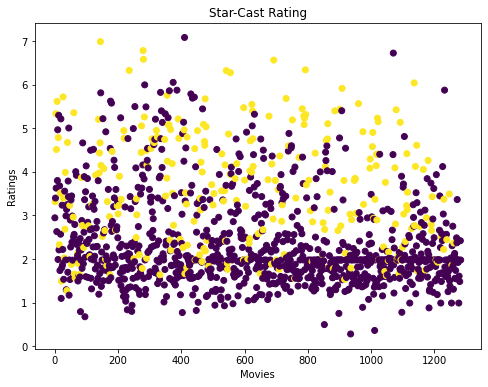

In [158]:
plt.figure(figsize=(8,6))
plt.scatter(movies_data['index'],movies_data['actors'],c=cluster.labels_)
plt.xlabel('Movies')
plt.ylabel('Ratings')
plt.title('''Star-Cast Rating''')

Text(0.5, 1.0, "Director's Rating")

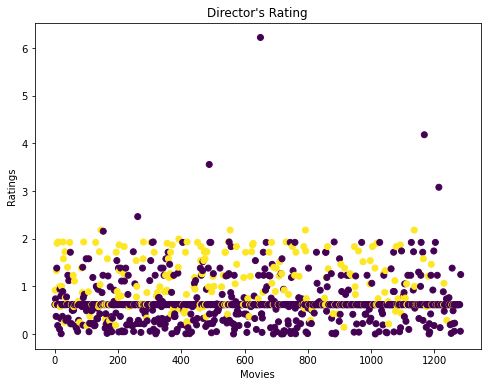

In [163]:
plt.figure(figsize=(8,6))
plt.scatter(movies_data['index'],movies_data['directors'],c=cluster.labels_)
plt.xlabel('Movies')
plt.ylabel('Ratings')
plt.title('''Director's Rating''')

# Model Evaluation........
Evaluating the model with real time data-case and anlysing the potential of clustring 

In [287]:
# required inputs

print(movies_data.keys())
df = pd.DataFrame()

Index(['index', 'title', 'actors', 'directors', 'sequel', 'hitFlop', 'Romance',
       'Western', 'War', 'Documentary', 'Animation', 'Horror', 'Sci-Fi',
       'Mystery', 'Musical', 'Adventure', 'Music', 'Sport', 'Family', 'Comedy',
       'Crime', 'History', 'Short', 'Fantasy', 'Drama', 'Action', 'Thriller',
       'Biography'],
      dtype='object')


The testing Data......

(scraping the real time data for testing)

In [352]:
# we scrape the data from web to achive real inputs.....
import urllib.request
import requests
import urllib.parse
from bs4 import BeautifulSoup

# we are using this tt0319736
id_ = input('Enter the movie ID : ')
data = urllib.request.urlopen('https://www.imdb.com/title/'+id_)
soup = BeautifulSoup(data,'html.parser') 
#data = soup.prettify()

Enter the movie ID : tt0319736


Testing Data Preprocessing

In [281]:
# creating scraped values into oraganised format

#directors
cast_crew =  soup.find_all(class_='credit_summary_item')

directors = cast_crew[0]
directors = directors.text[-18:-1]
print('director : ',directors)

#actors
actors = cast_crew[2]
actors = actors.text[8:45].split(',')
actors = ' |'.join(actors)
print('actors : ',actors)

director :  Rajkumar Santoshi
actors :  Ajay Devgn | Sushant Singh | D. Santosh


Creating attributes

In [321]:
# Creating the Testing DataFrame from scraped data

# attributes
check_data = {
    'index' : np.random.randint(300,700),
    'actors' : actors,
    'directors' : directors,
    'sequel' : 0,
    'hitFlop' : np.nan,
}

# genre attributes
for i in movies_data.keys()[6:]:
    check_data[i] = 0

df_ = pd.DataFrame([check_data])

genre = soup.find(class_='subtext')
genre = genre.text[-50:-24].split(', \n')

for i in genre:
    df_[i] = 1

df_.head()

,index,actors,directors,sequel,hitFlop,Romance,Western,War,Documentary,Animation,Horror,Sci-Fi,Mystery,Musical,Adventure,Music,Sport,Family,Comedy,Crime,History,Short,Fantasy,Drama,Action,Thriller,Biography
0,646,Ajay Devgn | Sushant Singh | D. Santosh,Rajkumar Santoshi,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1


Data conversion to rating

In [322]:
# final preprocessing of Testing Data

df_['actors'] = convert_to_rate(s='actors',df = df_['actors'])
df_['directors'] = convert_to_rate(s='directors',df = df_['directors'])

x_test = pd.concat((df_.iloc[:,1:4],df_.iloc[:,5:]),axis=1)

df_['hitFlop'] = np.round(model.predict(x_test))

df_.head()

,index,actors,directors,sequel,hitFlop,Romance,Western,War,Documentary,Animation,Horror,Sci-Fi,Mystery,Musical,Adventure,Music,Sport,Family,Comedy,Crime,History,Short,Fantasy,Drama,Action,Thriller,Biography
0,646,2.809569,0.620484,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1


#Results Visualization.......



		NOTE : our Prediction Data is red star



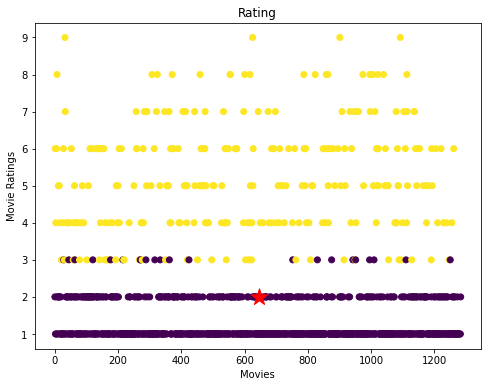

In [351]:
# plotting the predicted Data

plt.figure(figsize=(8,6))
plt.scatter(movies_data['index'],movies_data['hitFlop'],c=cluster.labels_)
plt.xlabel('Movies')
plt.ylabel('Movie Ratings')
plt.title('''Rating''')
plt.scatter(df_['index'],df_['hitFlop'],s=300,color='red',marker='*')
print('\n\n\t\tNOTE : our Prediction Data is red star')
print()



		NOTE : our Prediction Data is red star



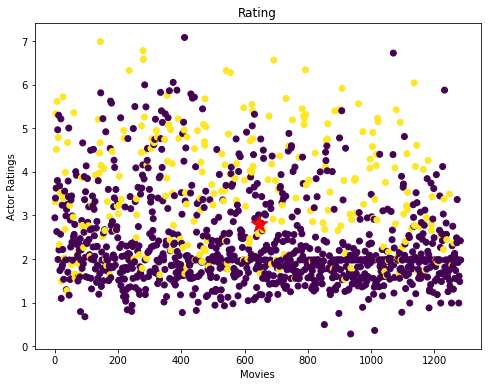

In [349]:
# Plotting the predicted Data

plt.figure(figsize=(8,6))
plt.scatter(movies_data['index'],movies_data['actors'],c=cluster.labels_)
plt.xlabel('Movies')
plt.ylabel('Actor Ratings')
plt.title('''Rating''')
plt.scatter(df_['index'],df_['actors'],s=300,color='red',marker='*')
print('\n\n\t\tNOTE : our Prediction Data is red star')
print()



		NOTE : our Prediction Data is red star



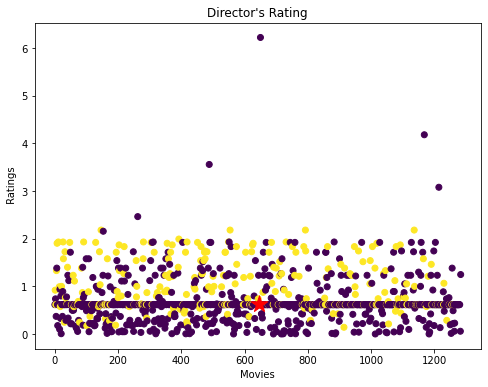

In [350]:
# Plotting the Predicted Data

plt.figure(figsize=(8,6))
plt.scatter(movies_data['index'],movies_data['directors'],c=cluster.labels_)
plt.xlabel('Movies')
plt.ylabel(' Ratings')
plt.title('''Director's Rating''')
plt.scatter(df_['index'],df_['directors'],s=300,color='red',marker='*')
print('\n\n\t\tNOTE : our Prediction Data is red star')
print()